In [ ]:
pip install google-auth==1.35.0 google-api-core==1.31.0 google-api-python-client

In [ ]:
pip install google-cloud-storage google-cloud-core

In [ ]:
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns

In [ ]:
# api_key = 'Insert your API Key here' #uncomment this to do so
channel_id = ''

In [ ]:
from googleapiclient.discovery import build

# API key
 # api_key = 'Insert your API Key here'

# Initialize YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Replace with the custom channel name or username
channel_name = 'GoogleDevelopers'

# Make a request to the API to search for the channel
request = youtube.channels().list(
    part='id,snippet',
    forUsername=channel_name
)
response = request.execute()

# Extract the channel ID
for channel in response['items']:
    print(f"Channel ID: {channel['id']}")

In [ ]:
from googleapiclient.discovery import build

# API key
api_key = 'Insert your API Key here'

# Initialize YouTube API client
youtube = build('youtube', 'v3', developerKey=api_key)

# Use the handle (without the @ symbol)
channel_handle = 'HouseOfHighbrations'

# Use the search method to find the channel by handle
search_response = youtube.search().list(
    part="snippet",
    q=channel_handle,
    type="channel",
    maxResults=1
).execute()

# Check if the response contains items
if 'items' in search_response and len(search_response['items']) > 0:
    # Extract the channel ID
    channel_id = search_response['items'][0]['snippet']['channelId']
    print(f"Channel ID: {channel_id}")
else:
    print("Channel not found or no results returned.")


In [ ]:
# api_key = 'Insert your API Key here'  uncomment this to insert your api key
#channel_id = 'UCBnHZUkOqg73h7gWiIu0ITA'

channel_ids = [ 'UC64KwGynvj3hA7T0C9gC5cA', 'UCBnHZUkOqg73h7gWiIu0ITA', 
               'UCoKJEWNZB8VxqrRLpguujGA', 'UCQjxn11O8QqMhPWApRcSUjw']


youtube = build('youtube', 'v3', developerKey = api_key)

## Function to get Channel Statistics 

In [ ]:
def get_channel_stats(youtube, channel_ids):
    all_data = []
    request = youtube.channels().list(
                      part='snippet, contentDetails, statistics', id = ','.join(channel_ids))
    response = request.execute()
    
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'], 
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']) #added uploads
        all_data.append(data)
                
    return all_data

In [ ]:
channel_statistics = get_channel_stats(youtube, channel_ids)

In [ ]:
channel_data = pd.DataFrame(channel_statistics)

In [ ]:
channel_data

In [ ]:
channel_data.dtypes

In [ ]:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])

In [ ]:
channel_data.dtypes

In [ ]:
sns.set(rc= {'figure.figsize': (10,8)})
ax = sns.barplot( x = 'Channel_name', y = 'Subscribers', data = channel_data)

In [ ]:
sns.set(rc= {'figure.figsize': (10,8)})
ax = sns.barplot( x = 'Channel_name', y = 'Views', data = channel_data)

In [ ]:
sns.set(rc= {'figure.figsize': (10,8)})
ax = sns.barplot( x = 'Channel_name', y = 'Total_videos', data = channel_data)

## Function to get videos IDs 

In [ ]:
channel_data 

In [ ]:
playlist_id = channel_data.loc[channel_data['Channel_name']== 'Tam Kaur', 'playlist_id'].iloc[0]

In [ ]:
playlist_id

In [ ]:
def get_video_ids(youtube, playlist_id):
    # Initial request to get the first page of video IDs
    request = youtube.playlistItems().list(
        part='contentDetails', 
        playlistId=playlist_id,
        maxResults=50
    )
    response = request.execute()
    
    video_ids = []
    
    # Append video IDs from the first page
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    # Pagination handling
    next_page_token = response.get('nextPageToken')
    
    while next_page_token:
        request = youtube.playlistItems().list(
            part='contentDetails',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()
        
        # Append video IDs from the subsequent pages
        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])
        
        # Update next_page_token to check for more pages
        next_page_token = response.get('nextPageToken')
    
    return video_ids

# Example usage
video_ids = get_video_ids(youtube, playlist_id)
print(video_ids)

In [137]:
def get_video_details(youtube, video_ids):
    all_video_stats = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
                       part= 'snippet, statistics', 
                       id = ','.join(video_ids[i:i+50]))

        response = request.execute()
        
        for video in response['items']:
            video_stats = dict(Title = video['snippet']['title'], 
                               Published_date = video['snippet']['publishedAt'], 
                               Views = video['statistics']['viewCount'],
                               Likes = video['statistics'].get('likeCount', 0),
                              #Dislikes = video['statistics']['viewCount'],
                               Comments = video['statistics']['commentCount']
                            )
            all_video_stats.append(video_stats)
            

    return all_video_stats

In [139]:
video_details = get_video_details(youtube, video_ids)

In [140]:
# Assuming 'video_details' is your list of video data
videos_with_na_likes = [video for video in video_details if video['Likes'] == 0]

# Print or inspect the videos with 'N/A' likes
print(videos_with_na_likes)


[{'Title': 'MY BOOK IS OUT NOW!', 'Published_date': '2024-08-17T14:58:00Z', 'Views': '82918', 'Likes': 0, 'Comments': '283'}]


In [141]:
video_details = pd.DataFrame(video_details)

In [142]:
video_details['Published_date'] = pd.to_datetime(video_details['Published_date']).dt.date
video_details['Views'] = pd.to_numeric(video_details['Views'])
video_details['Likes'] = pd.to_numeric(video_details['Likes'])
video_details['Comments'] = pd.to_numeric(video_details['Comments'])

In [144]:
video_details.dtypes

Title             object
Published_date    object
Views              int64
Likes              int64
Comments           int64
dtype: object

In [148]:
top_10_videos = video_details.sort_values(by = 'Views', ascending = False).head(10)

In [149]:
top_10_videos

,Title,Published_date,Views,Likes,Comments
185,how to VALIDATE YOURSELF | stop seeking extern...,2023-02-22,1851129,115608,2166
178,"how to be productive | discipline, healthy hab...",2023-04-07,1819906,75799,1007
188,HOW TO HAVE LUCKY GIRL SYNDROME: REAL tips to ...,2023-02-09,1779432,106187,1375
190,"how to build REAL confidence: self-worth tips,...",2023-01-30,1689499,80461,1176
192,HOW TO RADIATE FEMININE ENERGY TO LIVE A SOFT ...,2023-01-19,1441584,69683,1364
179,how to REALLY be a high value woman | high val...,2023-03-30,1335819,56607,950
166,HOW TO MANIFEST YOUR DREAM LIFE | ATTRACT ALL ...,2023-06-30,1318690,77956,1996
148,confidence baby.,2023-10-18,1085054,86565,438
156,how to CONQUER high school | back to school pr...,2023-08-25,1085051,73796,1361
181,how to emotionally DETACH | master detachment ...,2023-03-17,1073742,59267,1102


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


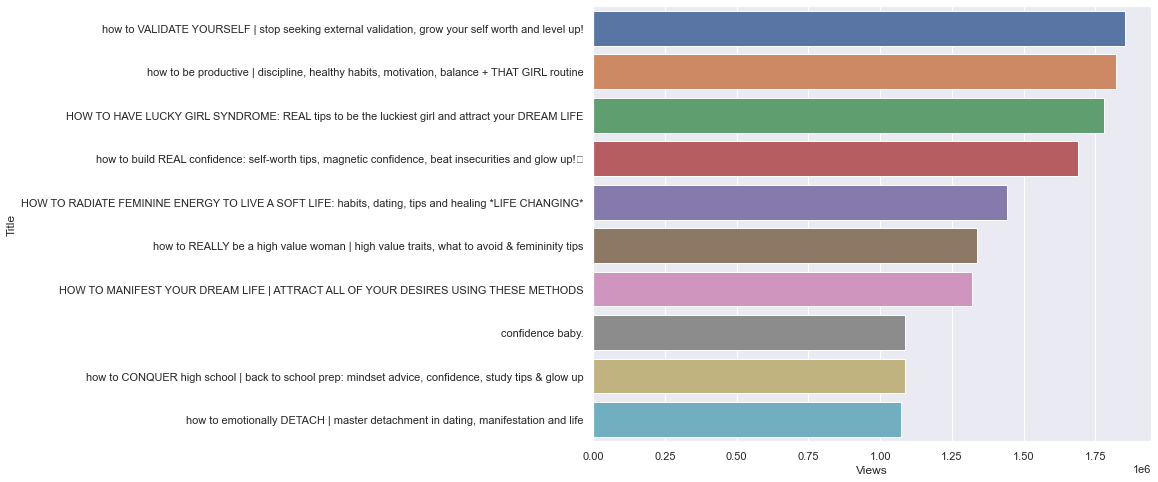

In [151]:
ax1 = sns.barplot(x= 'Views', y = 'Title', data = top_10_videos)

In [ ]:
df['DayOfWeek'] = df['DATE OCC'].dt.day_name()

In [153]:
video_details['Month'] = pd.to_datetime(video_details['Published_date']).dt.strftime('%b')

In [154]:
video_details

,Title,Published_date,Views,Likes,Comments,Month
0,get picky with your friends.,2024-10-20,21680,3407,24,Oct
1,the most EFFECTIVE journalling method,2024-10-16,32876,5446,18,Oct
2,SEEING MY BOOK IN STORE FOR THE FIRST TIME!!!,2024-10-13,85955,8758,62,Oct
3,hot girl book recommendations that will help y...,2024-10-11,63379,4813,237,Oct
4,Speaking up to close the gender pay gap. Watch...,2024-10-10,10408,661,8,Oct
...,...,...,...,...,...,...
206,one whole year of self-love reflection,2021-12-30,27361,1207,41,Dec
207,this will make you quit social media…,2021-09-24,40087,1950,55,Sep
208,How to Overcome Heartbreak / 7 Steps to GET OV...,2021-01-24,36933,1583,45,Jan
209,How I Became Confident | Tam Kaur,2021-01-10,138577,8157,159,Jan


In [157]:
# number of videos per month

videos_per_month = video_details.groupby('Month', as_index = False).size() #converting it to a df using as_index = False

In [158]:
videos_per_month

,Month,size
0,Apr,18
1,Aug,24
2,Dec,10
3,Feb,16
4,Jan,12
5,Jul,21
6,Jun,20
7,Mar,22
8,May,21
9,Nov,10


In [159]:
# To sort the above output by month - we will use the categorical index. Convert index into month value and sort them

# in order to do that we need a sort order 

sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [161]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories = sort_order, ordered = True)

In [164]:
videos_per_month = videos_per_month.sort_index()

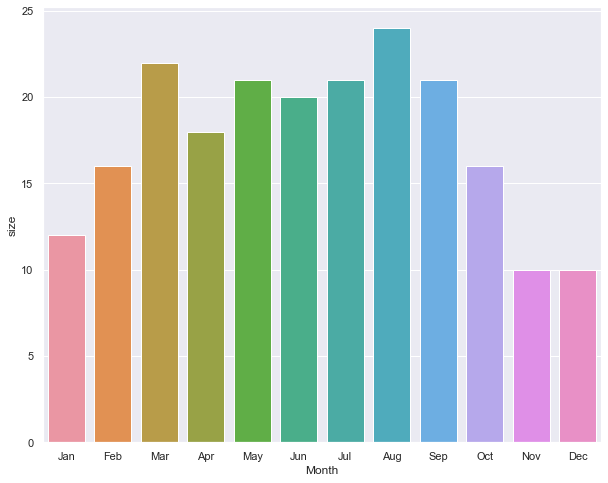

In [165]:
ax2 = sns.barplot(x = 'Month', y = 'size', data = videos_per_month)

In [166]:
video_details.to_csv('Video Details of Tam Kaur.csv')